<a href="https://colab.research.google.com/github/tsiligardi/PRA3024-Analysis-of-big-data-in-physics/blob/main/GWDA_Ex_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 69.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     

In [2]:
from google.colab import drive
drive.mount('/content/drive') #Mounting google drive on colab

Mounted at /content/drive


**PROBLEM 1**

In [3]:
#Import the usefull libraries
%matplotlib inline
import pylab
import lal
from pycbc.filter import highpass,matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass
import numpy as np
from pycbc import types
from pycbc.waveform import get_td_waveform,get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.psd
from pycbc.psd import interpolate
from pycbc.filter import sigma



Part 1: Download the data set from [1]. This data set contains a noise time series and an addi-
tional gravitational wave signal, where the sampling rate of the time series is 16384Hz.
The first column of the data set refers to the time. The second and third columns
are the data recorded by LIGO Hanford and Livingston, respectively. For the sake of
convenience in data analysis, we downsample the data at a sampling rate of 2048Hz

In [4]:
#Importing the data, assuming they are stored on drive and we are working on colab.
#I had to adopted this solutions, since the fram package suddenly stopped work for everyone
d = np.load('/content/drive/MyDrive/GW_noisedata-2.npy')
merger = Merger("GW170817")#getting the time of the event

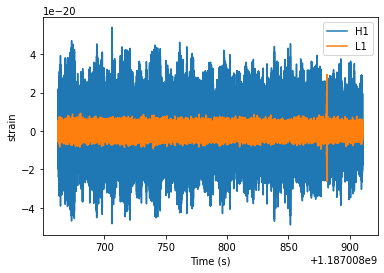

In [5]:
dt = d[:, 0]
i=1
strain, stilde = {}, {}
for ifo in ['H1', 'L1']:
  ts = types.TimeSeries(d[:, i], delta_t = dt[1]- dt[0],epoch=dt[0])#eopch: set start time of the time series
  #reading the time domain
  strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
  strain[ifo] = strain[ifo].crop(4, 4)
  #creating the frequency domain
  stilde[ifo] = strain[ifo].to_frequencyseries()
  i+=1

#Plotting
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


**Part 2** <br>Write down the code to calculate the matched filter between the given data and a
template waveform. After that, find out the template waveform for which the signal
to noise ratio is maximum. For simplicity, you can assume the template waveform is
produced from an equal mass binary system. Produce a plot which shows the SNR
versus total mass of the system, where masses of the systems are uniformly distributed
in a range 1M ≤ m1,2 ≤ 3M (use m1 = m2). Represent the result by fitting the
best match template waveform against the data. Also, show the chirp structure of the
signal over the time-frequency domain using Q-transformation().

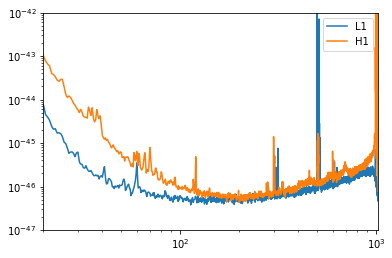

In [6]:
#To determine the signal to noise ration, we first need to determine the power spectral density
psds = {}
for ifo in ['L1', 'H1']:
    #setting parameters
    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    #calculating the PSD
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)
    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend();
#The plot was not specifically required by the assignment, but it it nice to have it

In [7]:
#generating the chirp mass
chirp_mass = np.arange(1.1966, 1.1996, .0001)
#converting to solar masses
masses = mass1_from_mchirp_q(chirp_mass, 1)#this is not the exact range required, but a smaller range allows better precision in determine the SNRs
#and, therefore, also better precision in the rest of the assignemt
#calculating the SNRs
snrs = []

for m in masses:
    #Generating the waveform
    hp, hc = get_fd_waveform(approximant="TaylorF2", 
                             mass1=m, mass2=m, 
                             f_lower=20, delta_f=stilde[ifo].delta_f)
    hp.resize(len(stilde[ifo]))
    
    # Matched filter the data and find the peak  
    max_snr={}
    for ifo in ['L1', 'H1']:
        snr = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=20.0)

        # determining the complex SNR at the peak
        snr = snr.time_slice(merger.time - 1, merger.time + 1)
        _, idx = snr.abs_max_loc()
        max_snr[ifo] = snr[idx]
        
    snrs.append(max_snr)


the best mass1=mass2 is 1.3756811499444492 solar masses


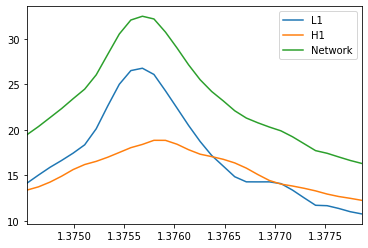

In [8]:
#separating the SNRs values of the two detectors
snrs_L1=[abs(snr['L1']) for snr in snrs]
snrs_H1=[abs(snr['H1']) for snr in snrs]

#determining the snr of the network
nsnr=np.sqrt((np.array(snrs_L1)**2+np.array(snrs_H1)**2))

#plotting
pylab.plot(masses,snrs_L1,label='L1')
pylab.plot(masses,snrs_H1,label='H1')
pylab.plot(masses,nsnr,label='Network')
pylab.xlim(min(masses),max(masses))
pylab.legend()

#determining the max index with the maximum snr
max_index=np.where(nsnr==max(nsnr))

print('the best mass1=mass2 is {} solar masses'.format(masses[max_index][0]))

The L1 detector shows an SNR>8, indicating that an event has been detected there. We can now used the best mass found to generate a new template and compare it with the data. We could do it with both detectors. 

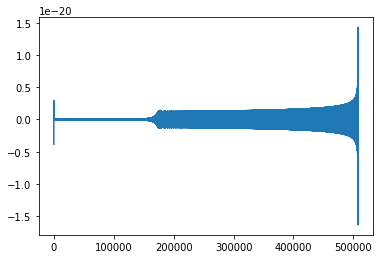

In [9]:
ifo='L1'#selecting the detector
data=stilde[ifo]#frequency serie from that detector
m=1.376#best mass

#The first step is getting the best waveform
hp, hc = get_fd_waveform(approximant="TaylorF2", 
                             mass1=m, mass2=m, 
                             f_lower=20, delta_f=data.delta_f)
hp.resize(len(data))

template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template.to_timeseries())
pylab.show()


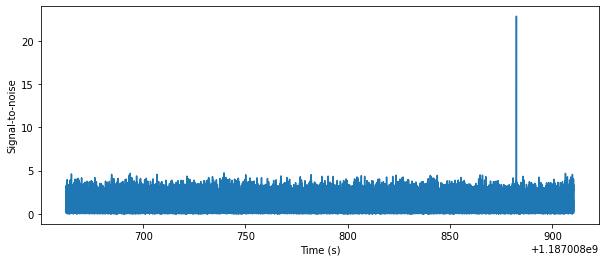

the peak of the snr is 22.836756671543277 at time= 1187008882.4429688


In [10]:
#Now I can calculate the time of the event (i.e, the time corresponding to the snr peak)
snr= matched_filter(template, data,
                     psd=psds[ifo], low_frequency_cutoff=20)
#Plot of the snr vs time
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

#Detecting the snr peak and its time
peak = abs(snr).numpy().argmax()
snr_peak = snr[peak]
t_peak = snr.sample_times[peak]

print('the peak of the snr is {} at time= {}'.format(abs(snr_peak),t_peak))

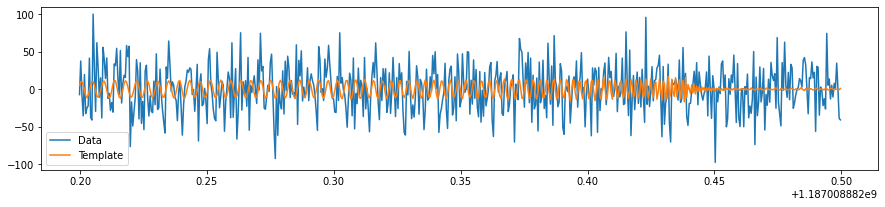

In [11]:
#with these data, I can now show how my template overlap with the signal
#first I need to withen the data, and convert them to a time series
white_data = (data / psds[ifo] ** 0.5).to_timeseries()
#Now I have to align my template and my data
dt =  t_peak - data.start_time
template_aligned=hp.cyclic_time_shift(dt)
template_aligned /= sigma(template_aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

#scaling the template
template_aligned*=snr_peak
template_aligned.start_time=data.start_time
#Now I whiten the template
white_template=(template_aligned/psds[ifo] ** 0.5).to_timeseries()

#selecting the time around the merger
white_data_plot=white_data.time_slice(merger.time-0.2,merger.time+0.1)
white_template_plot=white_template.time_slice(merger.time-0.2,merger.time+0.1)

#plotting
pylab.figure(figsize=[15, 3])
pylab.plot(white_data_plot.sample_times, white_data_plot, label="Data")
pylab.plot(white_template_plot.sample_times, white_template_plot, label="Template")
pylab.legend()
pylab.show()



Although the signal is very small we can see a nice overlapping between the template and the data, especially between 0.40s and 0.45s (+1.18e9 )

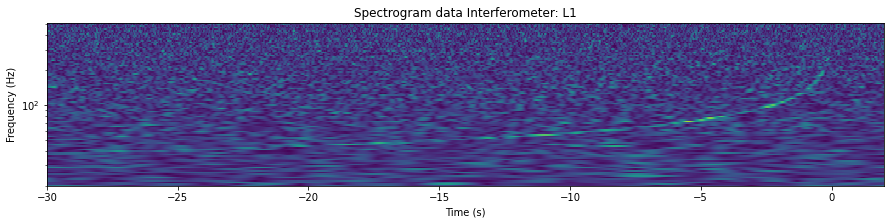

In [12]:
#Now I can take a look at the spectrogram. To do so, I need to do a q transform
#first, I plot the spectrogram of my data (i.e., the Q-transfor)
zoom = white_data.time_slice(merger.time - 30, merger.time + 2)

times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

pylab.figure(figsize=(15,3))
pylab.pcolormesh(times - merger.time, freqs, power**0.5, vmin=0, vmax=6)
pylab.ylim(20, 512)
pylab.title('Spectrogram data Interferometer: {}'.format(ifo))
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.yscale('log')


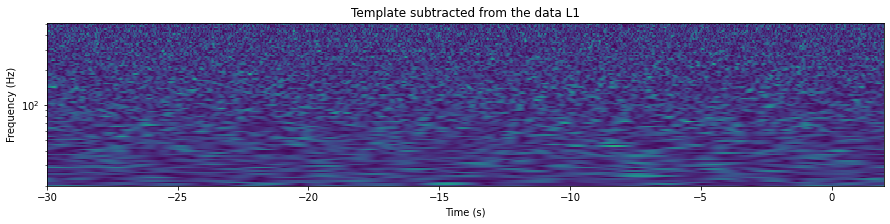

In [13]:
#Now I can subtrat the signal 
stilde2 = data - template_aligned

# Whiten the data
hoft = (stilde2 / psds[ifo] ** 0.5).to_timeseries()

# Select the time around the event
zoom = hoft.time_slice(merger.time - 30, merger.time + 2)

# Calculate the qtransform 
times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

#plotting
pylab.figure(figsize=(15,3))
pylab.pcolormesh(times - merger.time, freqs, power**0.5, vmin=0, vmax=6)
pylab.ylim(20, 512)
pylab.title('Template subtracted from the data {}'.format(ifo))
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.yscale('log')

As expected, in this second spectrogram the signal is missing, indicating that our template is a good fitting of it

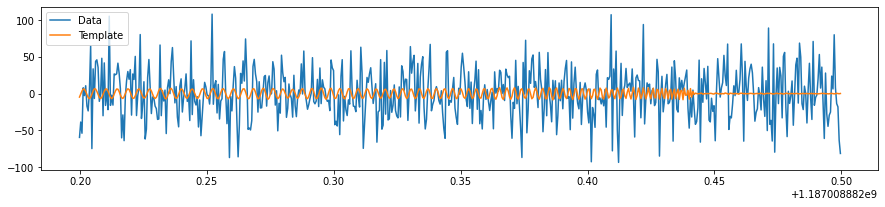

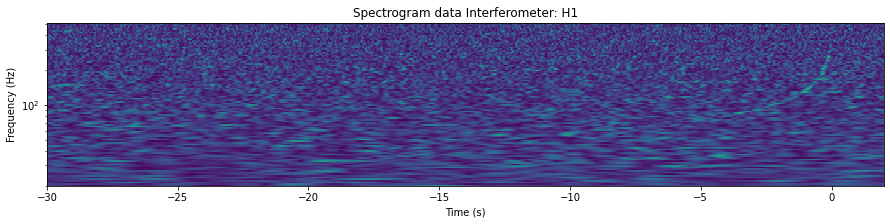

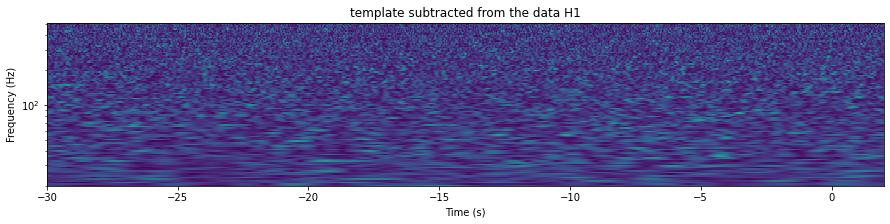

In [14]:
#Now I can repeat the same procdure of the H1 detector. Here I am only showing the overlapping and the spectrogram.
#If you would like to see all the graphs, you can change ifo to 'H1' in the cell at the beginning of this section.
ifo='H1'#selecting the detector
data=stilde[ifo]#frequency serie from that detector
m=1.38#best mass
#The first step is getting the best waveform
hp, hc = get_fd_waveform(approximant="TaylorF2", 
                             mass1=m, mass2=m, 
                             f_lower=20, delta_f=data.delta_f)
hp.resize(len(data))

template = hp.cyclic_time_shift(hp.start_time)
#Now I can calculate the time of the event (i.e, the time corresponding to the snr peak)
snr= matched_filter(template, data,
                     psd=psds[ifo], low_frequency_cutoff=20)

#Detecting the snr peak
peak = abs(snr).numpy().argmax()
snr_peak = snr[peak]#the peaks may be at slightly different times and, given that the signal is not too strong, it is better to redetect it

t_peak = snr.sample_times[peak]
#with these data, I can now show how my template overlap with the signal
#first I need to withen the data, and convert them to a time series
white_data = (data / psds[ifo] ** 0.5).to_timeseries()
#Now I have to align my template and my data
dt =  t_peak - data.start_time
template_aligned=hp.cyclic_time_shift(dt)
template_aligned /= sigma(template_aligned, psd=psds[ifo], low_frequency_cutoff=20.0)
template_aligned*=snr_peak#scaling the template
template_aligned.start_time=data.start_time
#Now I whiten the template
white_template=(template_aligned/psds[ifo] ** 0.5).to_timeseries()

#selecting the time around the merger
white_data_plot=white_data.time_slice(merger.time-0.2,merger.time+0.1)
white_template_plot=white_template.time_slice(merger.time-0.2,merger.time+0.1)

#plotting
pylab.figure(figsize=[15, 3])
pylab.plot(white_data_plot.sample_times, white_data_plot, label="Data")
pylab.plot(white_template_plot.sample_times, white_template_plot, label="Template")
pylab.legend()
pylab.show()
#Now I can take a look at the spectrogram. To do so, I need to do a q transform
#first, I plot the spectrogram of my data
zoom = white_data.time_slice(merger.time - 30, merger.time + 2)

times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

pylab.figure(figsize=(15,3))
pylab.pcolormesh(times - merger.time, freqs, power**0.5, vmin=0, vmax=6)
pylab.ylim(20, 512)
pylab.title('Spectrogram data Interferometer: {}'.format(ifo))
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.yscale('log')
pylab.show()
#Now I can subtrat the signal 
stilde2 = data - template_aligned

# Whiten the data
hoft = (stilde2 / psds[ifo] ** 0.5).to_timeseries()

# Select the time around the event
zoom = hoft.time_slice(merger.time - 30, merger.time + 2)

# Calculate the qtransform 
times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

pylab.figure(figsize=(15,3))
pylab.pcolormesh(times - merger.time, freqs, power**0.5, vmin=0, vmax=6)
pylab.ylim(20, 512)
pylab.title('template subtracted from the data {}'.format(ifo))
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.yscale('log')
pylab.show()

Also in this case, we can see that there is no singal in the second spectogram. In addition, the signal in the first one is less intense. This probabily dependents on the samller SNR of the H1 interferometer. 

**Part 3** <br>Here, we would like to investigate the correlation in the parameter space of gravita-
tional waves from compact binary coalescences. Let us consider a gravitational wave
h∗(t; m1,m2) generated from a binary with masses m1 = m2 = 10M . Now, we want
to understand how the nearby templates are correlated with that waveform. Calculate
the match between h∗(t; m1,m2) and the nearby templates that are generated assuming 5M ≤ m1,m2 ≤ 15M . Of course, one should have the maximum match (= 1)
when hi = h∗. You will see that the match between two nearby waveforms is not zero.
So, one can realize the gravitational waveforms are correlated for two nearby points
in the parameter space. This fact is used to produce a template bank for detecting
gravitational waves.

In [15]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match
mass=10
f_low=30
sample_rate=4096
#creating the first wave form for m=10
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=10,
                     mass2=10,
                     delta_t=1/sample_rate,
                     f_lower=30) 
mass_range = np.arange(5, 15,0.5 )#They are not many, but in this way I can speed up a bit the process
h_to_compare=[]#array to store the wave form that I have to compare with the other
for m in mass_range:
  sp,sc=get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=1/sample_rate,
                     f_lower=30)
  h_to_compare.append(sp)

#Resizing all the waveforms so that they all have te same size
tlen=max(len(hp),len(h_to_compare[0]))
hp.resize(tlen)
for i in h_to_compare:
  i.resize(tlen)
#Now I can compare them
m_values=[]
for h in h_to_compare:
  delta_f=1.0/h.duration
  flen=tlen//2 +1
  psd=aLIGOZeroDetHighPower(flen, delta_f,f_low)
  m,i=match(hp,h,psd=psd,low_frequency_cutoff=f_low)
  m_values.append(m)

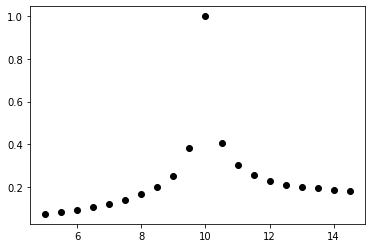

In [16]:
#Now I can plot the graph

pylab.plot(mass_range, m_values, 'o', color='black');


The plot shows what expected: the closer the waveforms get, the more correlated they are. The maximum is for m=10 (the two waveforms are the same).